In [1]:
# 2025 -06 20 fullnoise npts as input... fewer points, less spectacular additional uncertainty
# Canned investigation for 6-term model with mixture, asymmetric uncertainties, and fits the uncertainty.
#
# Requires parameter files *.ini listed a couple of cells below.
#
# test usage of npts input (to override parameter file for convenience, e.g. if that's all we're changing)

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool, cpu_count
import numpy as np
import matplotlib.pylab as plt
plt.ion()
from importlib import reload
import emcee
import time
import mcmc2d
import examine2d
import apply2d
import pickle

In [3]:
%matplotlib inline

In [4]:
# some strings we can change programmatically
npoints_arg = 40
styp='noobsnoise'

In [5]:
# param file now has c not log10(c). The acceptance fraction is quite low, so we rerun this with 6x the length
esargs, runargs, showargs = mcmc2d.setupmcmc(pathsim='eg11_sim_mix.ini', \
                                             pathfit='eg11_guess_mix_%s.ini' % (styp), 
                                             chainlen=150000, \
                                            doboots_poly=True, boots_ignoreweights=True, \
                                             pathboots='eg11_test_boots_nowts_n%i_%s.npy' % (npoints_arg,styp), \
                                             nboots=20000, \
                                            npoints_arg=npoints_arg)

mcmc2d.setupmcmc INFO - found sim, guess files eg11_sim_mix.ini, eg11_guess_mix_noobsnoise.ini
Simdata.loadconfig WARN - parse problems with keywords: ['alpha0', 'delta0']
Guess.loadconfig WARN - parse problems with keywords: ['alpha0', 'delta0']
mcmc2d.doguess DEBUG: guess transf: []
mcmc2d.doguess DEBUG - initialized guess parset:
[0. 0. 0. 0. 0. 0.]
[-6. -6.  2.]
[0.9 0.1]
[ -1.1 -10. ]
Guess degree: 1
mcmc2d.doguess DEBUG =======
fit2d.Guess.covobs2targ WARN - too few good obs covars: 0, 40
fit2d.Guess.updatelsq_covars INFO - shape mismatch between source and target covariances. Not updating.
fit2d.bootstraplsq INFO - starting 20000 non-parametric bootstrap samples...
fit2d.bootstraplsq INFO - bootstraps will ignore weights
fit2d.bootstraplsq INFO - ... done in 4.72e+00 seconds
Boots OK: 20000 of 20000
doguess DEBUG - parameter indices:
transf: [0 1 2 3 4 5]
lnoise: [6 7 8]
lsymm: [ 9 10]
lmix: [11 12]
labels: ['$A_{0}$', '$A_{1}$', '$A_{2}$', '$A_{3}$', '$A_{4}$', '$A_{5}$', '$log

showguess DEBUG - bbg: 3


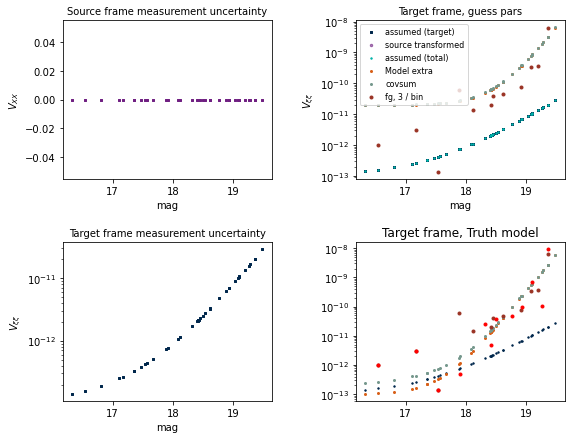

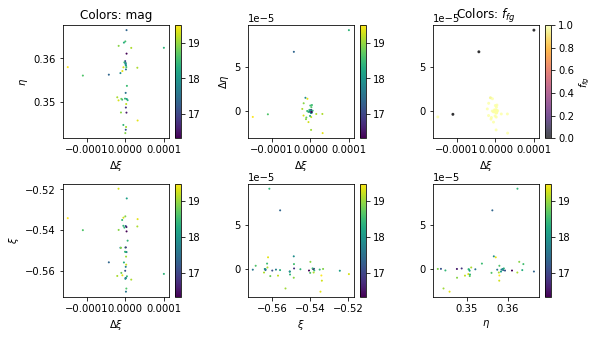

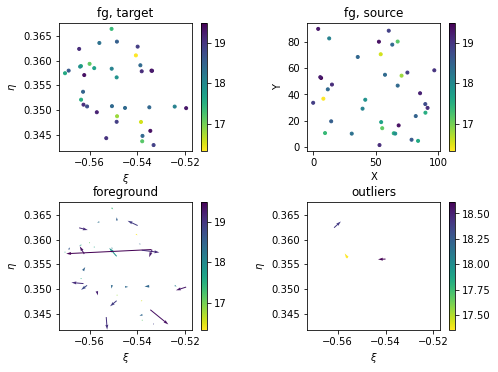

In [6]:
examine2d.showguess(esargs, nmagbins=10, showargs=showargs)

In [7]:
# local changes to showguess
# runargs.keys()

  0%|          | 0/150000 [00:00<?, ?it/s]/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 150000/150000 [1:11:15<00:00, 35.08it/s]


mcmc2d.getflatsamples INFO - measuring autocorrelation time:


/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


mcmc2d.getflatsamples INFO - max autocorr time: nan
mcmc2dgetflatsamples WARN - autocorr time is nan
mcmc2d.getflatsamples INFO - mean acceptance fraction: 0.30216309523809526 (28,) 0.0 0.31665333333333334
mcmc2d.getflatsamples INFO - retaining samples with finite lnprob 39420 40880
mcmc2d.getflatsamples INFO - flat samples shape: (39420, 13)
examine2d.showcorner INFO - plotting corner plot...
examine2d.showcorner INFO - highlighting nuisance parameters
examine2d.computeresps INFO - starting responsibility loop...
examine2d.computeresps INFO - iteration 39000 of 39420 after 5.22e+01 seconds: 747.3 it/sec. Est 5.62e-01 sec remain
examine2d.computeresps INFO - loops took 5.28e+01 seconds for 3.94e+04 samples
examine2d.writeresps INFO - writing responsibilities: (39420, 40)
computesamplescovars INFO - covs shape: (39420, 40, 2, 2)
computesamplescovars INFO - iteration 39000 of 39420 after 4.39e+01 seconds: 889.3 it/sec. Est 4.72e-01 sec remain
computesamplescovars INFO - computing percent

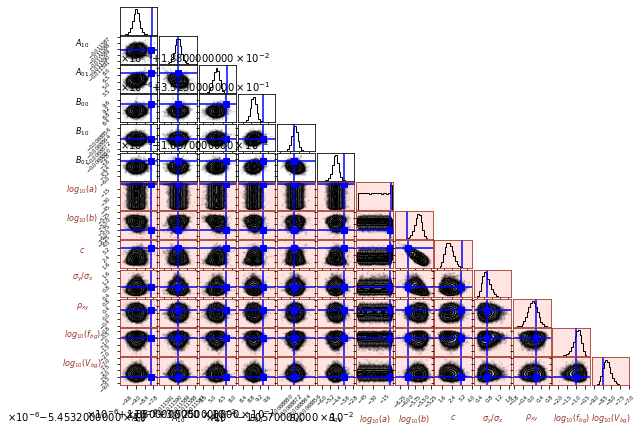

In [8]:
# OK so plots appear to work. Now try the sampling!
with Pool() as pool:
    sampler = emcee.EnsembleSampler(**esargs, pool=pool)
    sampler.run_mcmc(**runargs)
    flat_samples, lnprobs = mcmc2d.getflatsamples(sampler, \
                                                  pathflat='eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp), \
                                                 pathprobs='eg11_mix_twoframe_lnprobs_n%i_%s.npy' % (npoints_arg, styp))
    examine2d.showcorner(flat_samples, **showargs['corner'], pathfig='eg11_twoframe_corner_n%i_%s.png' % (npoints_arg, styp))
    FS = examine2d.Flatsamples(flat_samples, esargs=esargs, log_probs=lnprobs, showargs=showargs)
    FS.computeresps()
    FS.computesamplescovars()

In [ ]:
# write the "results" and the whole sampler to disk
FS.saveparset('test_parset_medians.pickle')
with open('test_sampler.pickle','wb') as wobj:
    pickle.dump(sampler, wobj)

In [9]:
# Compare covariance to lstsq
examine2d.showcovarscomp(FS)

showcovarscomp WARN - key not in dictionary: covpars


In [10]:
# some filename carpentry (save effort re-typing)
pathpset = 'eg11_test_parset_truth_n%i_%s.txt' % (npoints_arg, styp)
pathpguess = 'eg11_test_parset_guess_n%i_%s.txt' % (npoints_arg, styp)
pathsrc = 'eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp)
pathtarg = 'eg11_test_obs_targ_n%i_%s.dat' % (npoints_arg, styp)

pathshowargs = 'eg11_n%i_%s_test_showargs.pickle' % (npoints_arg, styp)
pathrunargs = 'eg11_n%i_%s_test_runargs.pickle' % (npoints_arg, styp)
pathesargs = 'eg11_n%i_%s_test_esargs.pickle' % (npoints_arg, styp)

os.rename('test_parset_truth.txt',pathpset)
os.rename('test_parset_guess.txt',pathpguess)
os.rename('test_obs_src.dat', pathsrc)
os.rename('test_obs_targ.dat', pathtarg)

os.rename('test_showargs.pickle', pathshowargs)
os.rename('test_runargs.pickle', pathrunargs)
os.rename('test_esargs.pickle', pathesargs)

In [11]:
# copy some files across in order for the following to play nice
#!cp -p test_parset_truth.txt eg10_test_parset_truth_n300_fullnoise.txt
#!cp -p test_parset_guess.txt eg10_test_parset_guess_n300_fullnoise.txt
#!cp -p test_obs_src.dat eg10_test_obs_src_n300_fullnoise.dat

#!cp -p test_showargs.pickle eg10_fullnoise_test_showargs.pickle
#!cp -p test_runargs.pickle eg10_fullnoise_test_runargs.pickle
#!cp -p test_esargs.pickle eg10_fullnoise_test_esargs.pickle

In [12]:
fsfile='eg11_n%i_%s_flatsamples.pickle' % (npoints_arg, styp)
pickle.dump(FS, open(fsfile, 'wb'))

eg11_test_parset_truth_n40_noobsnoise.txt Poly
[0 1 2 3 4 5]
traceplot DBG: (39420, 13) (39420,)
eg11_mix_twoframe_flatsamples_n40_noobsnoise.npy
eg11_mix_twoframe_lnprobs_n40_noobsnoise.npy
DBG: grid line IDs:
300
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
samples_z DEBUG: (1000, 300) (39420,)
300000
(1000, 300)


(0.35, 0.355)

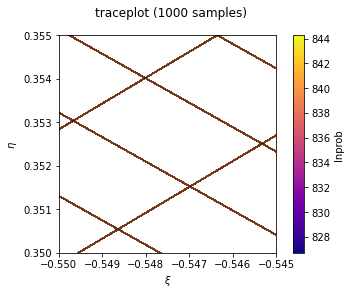

In [13]:
# apply local changes
reload(apply2d)

# Try a traceplot - may be hard to see the range for this example...
apply2d.traceplot(1000,'eg11_test_parset_truth_n%i_%s.txt' % (npoints_arg, styp),\
                  'eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp), \
                 pathlnprobs='eg11_mix_twoframe_lnprobs_n%i_%s.npy' % (npoints_arg, styp), \
                 scmap='plasma')
plt.gca().set_xlim(-0.55,-0.545)
plt.gca().set_ylim(0.350,0.355)

In [14]:
# apply some changes made locally between runs
reload(apply2d)

<module 'apply2d' from '/Users/wiclarks/Projects/random-prototypes/python/apply2d.py'>

eg11_test_parset_guess_n40_noobsnoise.txt Poly
sample_uncty INFO - starting 2.50e+03 flat samples...
sample_uncty INFO - ... done in 2.26e+00 seconds
sample_uncty INFO - starting 2.50e+03 MC samples...
sample_uncty INFO - ... done in 1.42e+00 seconds
(40,) (40,) (40,)


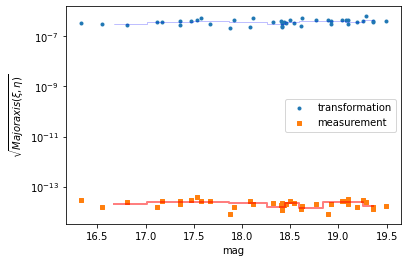

In [15]:
# Compare transformation uncertainty with pointing uncertainty
apply2d.eval_uncty(2500,'eg11_test_parset_guess_n%i_%s.txt' % (npoints_arg, styp), \
                   'eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp),\
                   'eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp), nbins=10)

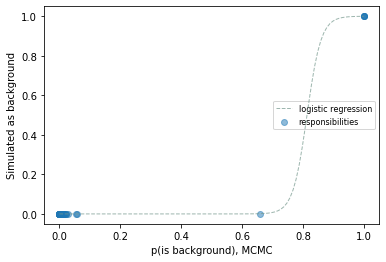

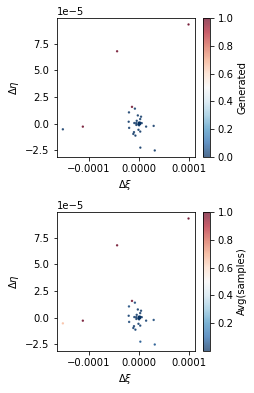

In [16]:
# incorporate local edits
# reload(examine2d)

# Since this was a mixture model, show the responsibilities
examine2d.showresps(FS)

showparsamples DEBUG: [1 2 3 5 4 6] 6 6


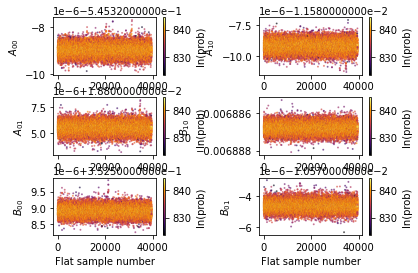

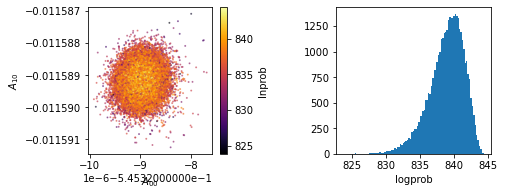

In [17]:
examine2d.showparsamples(FS)

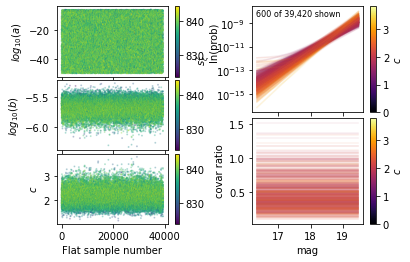

In [18]:
# shownoisesamples only makes sense if noise vs mag...
examine2d.shownoisesamples(FS, nshow=600, alpha=0.08, cmap='inferno', jaux=2)

showunctysamples INFO - mags, pctiles, levels: (40,) (5,) (5, 40, 2, 2)


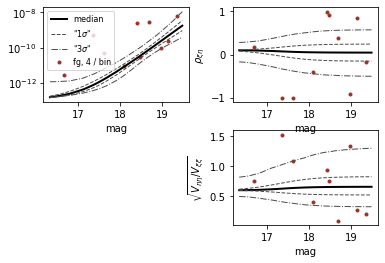

In [19]:
# how do those uncertainty bins look as percentiles?
examine2d.showunctysamples(FS)

In [20]:
showargs['corner']

{'truths': array([-5.45327955e-01, -1.15892202e-02,  1.88070429e-02,  3.52509342e-01,
        -6.88683671e-03, -1.05737756e-02, -6.50000000e+00, -6.00000000e+00,
         3.16000000e+00,  7.00000000e-01,  2.00000000e-01, -1.00000000e+00,
        -8.50000000e+00]),
 'labels': ['$A_{00}$',
  '$A_{10}$',
  '$A_{01}$',
  '$B_{00}$',
  '$B_{10}$',
  '$B_{01}$',
  '$log_{10}(a)$',
  '$log_{10}(b)$',
  '$c$',
  '$\\sigma_y/\\sigma_x$',
  '$\\rho_{xy}$',
  '$log_{10}(f_{bg})$',
  '$log_{10}(V_{bg})$'],
 'nmodel': 6,
 'inds_abc': array([0, 1, 2, 3, 4, 5])}

eg11_test_parset_truth_n40_noobsnoise.txt Poly
sample_transf INFO - running samples...
sample_transf INFO - ... done.
[0 1 1 3] [1. 0. 0. 1.]


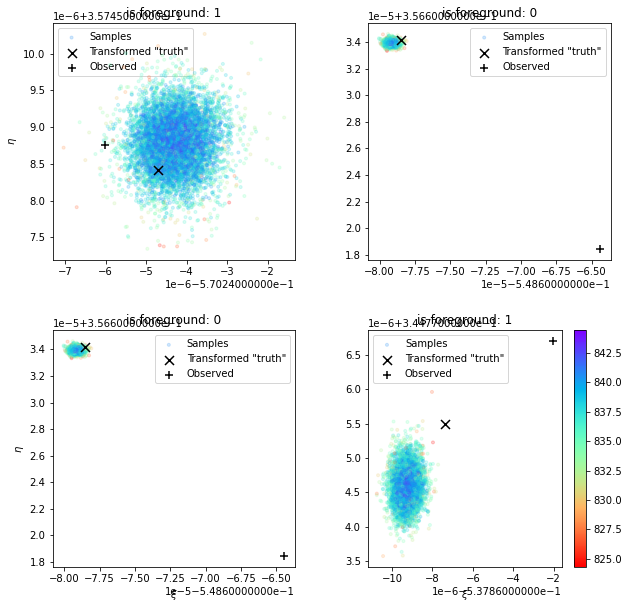

In [21]:
reload(apply2d)
apply2d.sample_transf(8000, pathpset='eg11_test_parset_truth_n%i_%s.txt' % (npoints_arg, styp), \
                      pathflat='eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp), \
                      pathobs='eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp), \
                 pathlnprobs='eg11_mix_twoframe_lnprobs_n%i_%s.npy' % (npoints_arg, styp), alpha=0.2,\
                     pathtarg='eg11_test_obs_targ_n%i_%s.dat' % (npoints_arg, styp))

eg11_test_parset_truth_n40_noobsnoise.txt Poly
unctysamples INFO - transformation name: Poly
unctysamples INFO - starting 5.00e+03 MC samples...
... done in 2.84e+00 seconds
Computing moments...

... done in 1.98e-02 seconds.
(40, 2)
(40, 2)
(40, 2, 2)
(0,)
Offset INFO - median offset: [0. 0.]
lsq pars: [ 0.0000000e+00  1.0000000e+00 -5.4487339e-17  0.0000000e+00
  0.0000000e+00  1.0000000e+00]
lsq geom: [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
 -1.56094728e-15 -3.12189456e-15]


LinAlgError: singular matrix

/Users/wiclarks/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:679: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/wiclarks/anaconda3/lib/python3.7/site-packages/matplotlib/quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


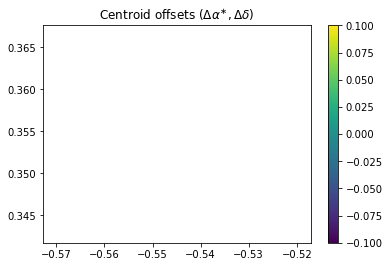

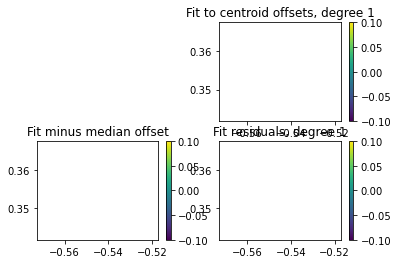

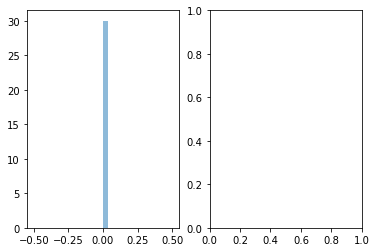

In [22]:
# Now draw samples from the projected uncertainty
apply2d.unctysamples(5000, \
                     'eg11_test_parset_truth_n%i_%s.txt' % (npoints_arg, styp),\
                     'eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp))